# Conditional Autoencoder for Asset Pricing

This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_trading_data](05_conditional_autoencoder_for_trading_data.ipynb). The results will vary depending on which ticker downloads succeeded.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
from time import time
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [6]:
results_path = Path('results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [7]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [8]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results/asset_pricing/autoencoder.h5
/close                      frame        (shape->[7559,3657]) 
/factor/beta                frame        (shape->[2363186,1]) 
/factor/betasq              frame        (shape->[2363186,1]) 
/factor/chmom               frame        (shape->[2700206,1]) 
/factor/dolvol              frame        (shape->[2806487,1]) 
/factor/idiovol             frame        (shape->[2363186,1]) 
/factor/ill                 frame        (shape->[2572109,1]) 
/factor/indmom              frame        (shape->[2849516,1]) 
/factor/maxret              frame        (shape->[2856033,1]) 
/factor/mom12m              frame        (shape->[2700206,1]) 
/factor/mom1m               series       (shape->[2871156])   
/factor/mom36m              frame        (shape->[2361477,1]) 
/factor/mvel                frame        (shape->[2874317,1]) 
/factor/retvol              frame        (shape->[2871156,1]) 
/factor/turn                fram

### Weekly returns

In [9]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['1993':, :], :])

In [10]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [11]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [12]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [13]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5152713 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2019-12-27 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      2770456 non-null  float64
 1   beta         2360139 non-null  float64
 2   betasq       2360139 non-null  float64
 3   chmom        2626339 non-null  float64
 4   dolvol       2704165 non-null  float64
 5   idiovol      2360139 non-null  float64
 6   ill          2489829 non-null  float64
 7   indmom       2770303 non-null  float64
 8   maxret       2748720 non-null  float64
 9   mom12m       2626339 non-null  float64
 10  mom1m        2760621 non-null  float64
 11  mom36m       2358433 non-null  float64
 12  mvel         2761081 non-null  float64
 13  retvol       2760621 non-null  float64
 14  turn         2677256 non-null  float64
 15  turn_std     2705590 non-null  fl

In [14]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

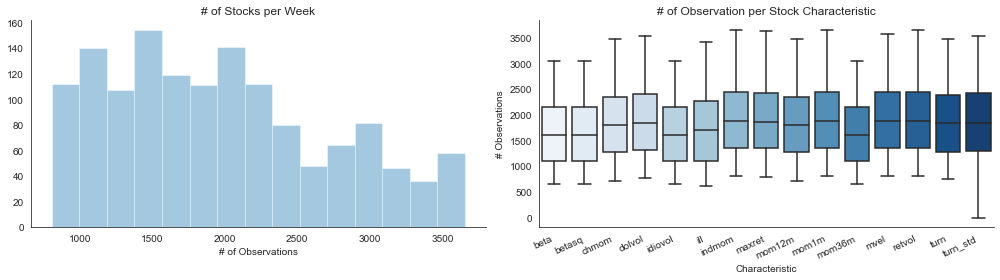

In [15]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()

### Rank-normalize characteristics

In [16]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [17]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5152713 entries, (Timestamp('1993-01-01 00:00:00', freq='W-FRI'), 'A') to (Timestamp('2019-12-27 00:00:00', freq='W-FRI'), 'ZYME')
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   returns      2770456 non-null  float64
 1   beta         2360139 non-null  float64
 2   betasq       2360139 non-null  float64
 3   chmom        2626339 non-null  float64
 4   dolvol       2704165 non-null  float64
 5   idiovol      2360139 non-null  float64
 6   ill          2489829 non-null  float64
 7   indmom       2770303 non-null  float64
 8   maxret       2748720 non-null  float64
 9   mom12m       2626339 non-null  float64
 10  mom1m        2760621 non-null  float64
 11  mom36m       2358433 non-null  float64
 12  mvel         2761081 non-null  float64
 13  retvol       2760621 non-null  float64
 14  turn         2677256 non-null  float64
 15  turn_std     2705590 non-null  fl

In [18]:
data.index.names

FrozenList(['date', 'ticker'])

In [19]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,2.770456e+06,2.360139e+06,2.360139e+06,2.626339e+06,2.704165e+06,2.360139e+06,2.489829e+06,2.770303e+06,2.748720e+06,2.626339e+06,2.760621e+06,2.358433e+06,2.761081e+06,2.760621e+06,2.677256e+06,2.705590e+06,2.769651e+06
mean,3.056325e-03,-6.346325e-09,-5.837470e-07,-3.568177e-09,-1.705488e-06,-2.294799e-07,-5.689239e-07,-6.601156e-02,3.892305e-09,-2.118056e-07,-3.516596e-08,-2.538978e-07,7.696316e-08,-2.838747e-05,-7.312079e-07,-1.196178e-06,3.053796e-03
std,5.971123e-02,5.776945e-01,5.776952e-01,5.776593e-01,5.776536e-01,5.776947e-01,5.776766e-01,5.943010e-01,5.776439e-01,5.776594e-01,5.776404e-01,5.776946e-01,5.776445e-01,5.776925e-01,5.776546e-01,5.776515e-01,5.971491e-02
min,-9.990779e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.990779e-01
25%,-2.083260e-02,-5.003208e-01,-5.003129e-01,-5.002485e-01,-5.002425e-01,-5.003047e-01,-5.002694e-01,-6.050328e-01,-5.002516e-01,-5.002384e-01,-5.001822e-01,-5.002966e-01,-5.002188e-01,-5.002597e-01,-5.001962e-01,-5.002272e-01,-2.083303e-02
50%,1.052650e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.303063e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.052504e-03
75%,2.457069e-02,5.003180e-01,5.003072e-01,5.002701e-01,5.002333e-01,5.003176e-01,5.002665e-01,4.275164e-01,5.002268e-01,5.002394e-01,5.002492e-01,5.002883e-01,5.002044e-01,5.002251e-01,5.002270e-01,5.002306e-01,2.456899e-02
max,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [20]:
data = data.loc[idx[:'2019', :], :]

In [21]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [22]:
data = data.fillna(-2)

In [23]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [8]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [9]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [10]:
n_tickers

3657

In [11]:
n_characteristics

15

### Input Layer

In [12]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [13]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [14]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [15]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [16]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [17]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_beta (InputLayer)         [(None, 3657, 15)]   0                                            
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 3657, 8)      128         input_beta[0][0]                 
__________________________________________________________________________________________________
batch_norm (BatchNormalization) (None, 3657, 8)      32          hidden_layer[0][0]               
__________________________________________________________________________________________________
input_factor (InputLayer)       [(None, 3657)]       0                                            
______________________________________________________________________________________________

## Train Model

### Cross-validation parameters

In [19]:
YEAR = 52

In [20]:
cv = MultipleTimeSeriesCV(n_splits=5, 
                          train_period_length=20*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [21]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [23]:
factor_opts = [2, 3, 4, 5, 6]
unit_opts = [8, 16, 32]

In [24]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [25]:
batch_size = 32

In [26]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [27]:
start = time()
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val,
                                                             X2_val]).reshape(-1),
                                    'y_true': y_val.stack().values},
                                   index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')            
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

00:00:03 | 2 08 | 00-000 | -0.24% |  0.06% | -1.32%
00:00:30 | 2 08 | 00-050 |  1.52% | -0.45% | -0.83%
00:00:57 | 2 08 | 00-100 |  3.01% |  0.26% | -1.73%
00:01:24 | 2 08 | 00-150 |  2.59% |  1.10% |  0.36%
00:01:51 | 2 08 | 00-200 |  2.29% |  0.97% |  0.72%
00:02:17 | 2 08 | 01-000 |  2.56% |  1.92% |  2.28%
00:02:43 | 2 08 | 01-050 |  2.03% |  0.28% |  1.44%
00:03:09 | 2 08 | 01-100 |  0.83% |  2.05% |  4.18%
00:03:35 | 2 08 | 01-150 |  1.69% |  1.38% |  3.73%
00:04:01 | 2 08 | 01-200 | -1.45% | -0.48% | -0.74%
00:04:25 | 2 08 | 02-000 | -1.37% | -1.83% | -2.87%
00:04:52 | 2 08 | 02-050 |  0.16% | -0.13% | -0.52%
00:05:19 | 2 08 | 02-100 |  1.33% |  1.39% |  1.78%
00:05:45 | 2 08 | 02-150 |  0.99% |  0.97% |  1.26%
00:06:11 | 2 08 | 02-200 |  1.80% |  1.55% |  2.80%
00:06:36 | 2 08 | 03-000 | -1.47% | -0.80% | -1.90%
00:07:03 | 2 08 | 03-050 | -0.41% | -0.35% | -2.67%
00:07:28 | 2 08 | 03-100 |  0.61% |  1.38% | -0.42%
00:07:51 | 2 08 | 03-150 | -1.48% | -1.25% | -0.11%
00:08:14 | 2

01:12:41 | 3 16 | 01-150 | -1.52% |  0.66% |  1.53%
01:13:10 | 3 16 | 01-200 | -1.13% | -0.74% | -1.39%
01:13:43 | 3 16 | 02-000 | -1.25% | -0.97% | -1.18%
01:14:10 | 3 16 | 02-050 | -0.86% | -1.06% | -1.49%
01:14:40 | 3 16 | 02-100 | -1.12% | -0.82% | -0.01%
01:15:06 | 3 16 | 02-150 |  2.52% |  2.16% |  2.97%
01:15:37 | 3 16 | 02-200 |  0.46% |  0.68% |  0.28%
01:16:13 | 3 16 | 03-000 |  1.72% |  1.41% |  0.80%
01:16:43 | 3 16 | 03-050 |  0.18% |  0.12% | -1.24%
01:17:12 | 3 16 | 03-100 |  0.03% |  0.04% |  0.32%
01:17:49 | 3 16 | 03-150 | -0.75% | -1.11% | -1.28%
01:18:18 | 3 16 | 03-200 |  0.82% |  0.27% |  0.64%
01:18:53 | 3 16 | 04-000 |  0.77% |  1.31% |  0.01%
01:19:22 | 3 16 | 04-050 |  0.77% |  0.40% | -3.04%
01:19:52 | 3 16 | 04-100 |  0.83% |  1.13% |  0.58%
01:20:23 | 3 16 | 04-150 | -0.16% | -0.32% |  1.76%
01:20:52 | 3 16 | 04-200 |  0.13% | -0.21% |  2.14%
01:21:29 | 4 16 | 00-000 |  3.51% |  2.89% |  3.23%
01:22:00 | 4 16 | 00-050 |  0.62% |  1.24% |  0.96%
01:22:31 | 4

02:59:16 | 4 32 | 03-050 |  2.26% |  1.44% |  1.23%
02:59:41 | 4 32 | 03-100 |  0.56% |  0.28% | -1.49%
03:00:05 | 4 32 | 03-150 |  1.58% |  1.06% |  1.86%
03:00:30 | 4 32 | 03-200 |  4.93% |  1.76% | -0.40%
03:00:55 | 4 32 | 04-000 | -2.71% | -1.63% | -1.81%
03:01:19 | 4 32 | 04-050 | -0.12% | -0.69% |  0.64%
03:01:43 | 4 32 | 04-100 | -1.33% | -2.24% | -3.16%
03:02:07 | 4 32 | 04-150 |  3.42% |  2.37% |  2.86%
03:02:32 | 4 32 | 04-200 |  1.83% |  1.21% | -1.68%
03:02:58 | 5 32 | 00-000 |  2.18% |  1.41% |  1.91%
03:03:23 | 5 32 | 00-050 | -0.11% |  1.47% |  1.79%
03:03:48 | 5 32 | 00-100 |  0.35% |  1.34% |  1.53%
03:04:12 | 5 32 | 00-150 |  0.33% |  0.65% |  0.39%
03:04:36 | 5 32 | 00-200 |  0.55% | -0.31% | -0.22%
03:05:01 | 5 32 | 01-000 |  2.43% |  1.36% |  1.22%
03:05:26 | 5 32 | 01-050 | -0.20% | -0.08% |  0.09%
03:05:54 | 5 32 | 01-100 |  2.05% |  2.33% |  2.85%
03:06:18 | 5 32 | 01-150 |  0.26% |  0.21% | -0.57%
03:06:43 | 5 32 | 01-200 |  1.97% |  0.95% |  0.98%
03:07:08 | 5

### Evaluate Results

In [23]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [24]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18750 entries, 0 to 1249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            18750 non-null  int64  
 1   n_factors        18750 non-null  int64  
 2   fold             18750 non-null  int64  
 3   epoch            18750 non-null  int64  
 4   ic_mean          18750 non-null  float64
 5   ic_daily_mean    18750 non-null  float64
 6   ic_daily_std     18750 non-null  float64
 7   ic_daily_median  18750 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [25]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [28]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
5         8              5      8    162  0.046922       0.029146   
          8              5      8    141  0.058828       0.029581   
          8              5      8     74  0.042003       0.026353   
          8              5      8      2  0.078509       0.034448   
          8              5      8    131  0.038715       0.024700   
2         16             2     16    151  0.017604       0.023406   
4         8              4      8      3  0.030489       0.025923   
          8              4      8     14  0.018523       0.018433   
          8              4      8      6  0.027900       0.023967   
6         16             6     16     71  0.014876       0.013128   

                 ic_daily_median  
n_factors units                   
5         8             0.034003  
          8             0.031755  
          8             0.030491  
          8             0.030237  
          8             0.029099  
2         16            0.029056  
4         8             0.028632  
          8             0.026335  
          8             0.024697  
6         16            0.023805

In [39]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
2412,5,8,162,0.046922,0.029146,0.034003
2391,5,8,141,0.058828,0.029581,0.031755
2324,5,8,74,0.042003,0.026353,0.030491
2252,5,8,2,0.078509,0.034448,0.030237
2381,5,8,131,0.038715,0.024700,0.029099
401,2,16,151,0.017604,0.023406,0.029056
2383,5,8,133,0.029274,0.024345,0.028807
1503,4,8,3,0.030489,0.025923,0.028632
2306,5,8,56,0.056498,0.031930,0.027303
2386,5,8,136,0.036864,0.025605,0.026759


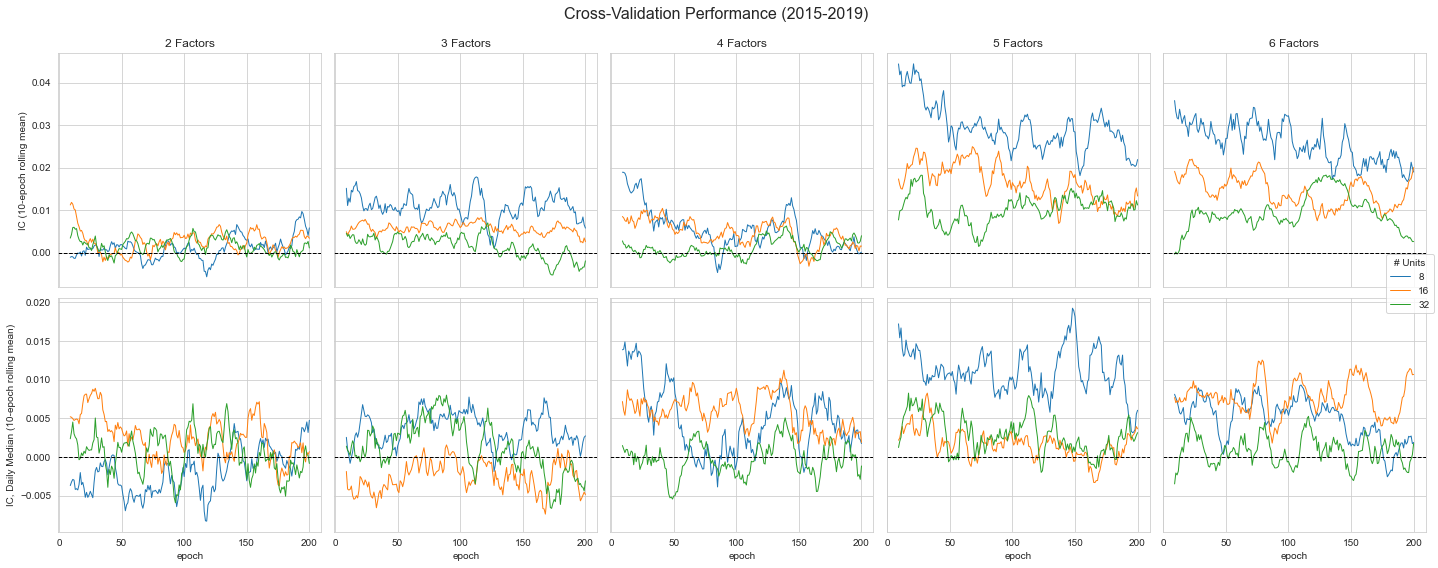

In [26]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=300);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [26]:
n_factors = 5
units = 8
batch_size = 32

In [ ]:
predictions = []
for i, epoch in enumerate(range(130, 170)):
    epoch_preds = []
    print(f'\nEpoch: {epoch}')
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)

        model = make_model(n_factors=n_factors, hidden_units=units)
        model.fit([X1_train, X2_train], y_train,
                  batch_size=batch_size,
                  epochs=epoch,
                  verbose=0,
                  shuffle=True)
        epoch_preds.append(pd.Series(model.predict([X1_val, X2_val]).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

In [ ]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [ ]:
predictions_combined.info()

In [ ]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')